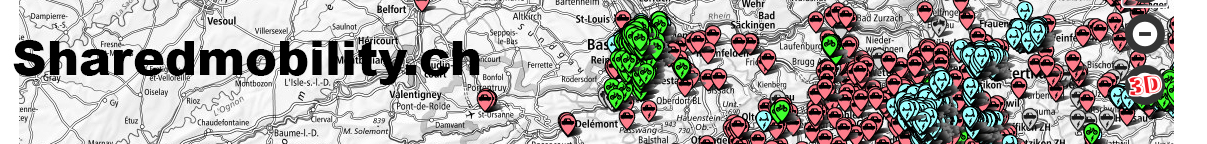

# Swiss Shared-Mobility Station Distribution Insights: MongoDB Data Integration, Visualization, and Accessibility Analysis

<a id="0"></a> <br>
 # Table of Contents  
1. [Summary](#1)     
2. [Requirements](#2) 
3. [ELT Process](#3)
   1. [DB Setup](#7)
   2. [Utilities](#5)
   3. [Data Structure](#7)
   4. [Extract](#7)
4. [Load Data & Exploratory¶](#4)     
5. [Annalysis](#6)         
6. [Conclusion](#12)       
7. [Learning](#13)      
 


## Summary

Shared Mobility represents an innovative approach to address the mounting challenges in the transportation sector while simultaneously reducing overall energy consumption. At the heart of this solution is the concept of Mobility as a Service (MaaS), which is instrumental in reshaping the way we view various modes of transportation, including cars, scooters, and bikes. Instead of treating these as personal assets, MaaS transforms them into on-demand services, making them accessible to a wider audience. This paradigm shift toward multi-modal mobility emphasizes collaboration among all mobility service providers and relies on the availability and seamless integration of real-time data.

The primary focus of this project is data integration, modeling, and data cleaning. It starts by retrieving data from an API and storing it in a MongoDB database, laying the foundation for comprehensive analysis and data visualization.

To gain a deeper understanding of the mobility landscape, a simple machine learning model is employed, primarily concentrating on classification. This approach aims to unearth underlying patterns within the data. It's important to note that the project is not primarily driven by real-world applications; instead, it seeks to determine whether it's feasible to discover meaningful patterns. The project delves into questions related to accessibility, service availability, and population statistics. The insights obtained from this analysis contribute to a more profound understanding of mobility trends, offering valuable information to make informed decisions aimed at optimizing future transportation solutions.


## Requirements

- fastjsonschema: 2.18.1
- geopandas: 0.14.0
- greenlet: 3.0.0
- json5: 0.9.14
- jsonpointer: 2.4
- jsonschema: 4.19.1
- jsonschema-specifications: 2023.7.1
- jupyter-contrib-core: 0.4.2
- jupyter_core: 5.3.2
- matplotlib: 3.8.0
- matplotlib-inline: 0.1.6
- numpy: 1.26.0
- pandas: 2.1.1
- pickleshare: 0.7.5
- pure-eval: 0.2.2
- pymongo: 4.5.0
- python-json-logger: 2.0.7
- referencing: 0.30.2
- requests: 2.31.0
- random2: 1.0.1
- seaborn: 0.13.0
- scikit-learn: 1.3.2
- threadpoolctl: 3.2.0
- urllib3: 2.0.6


In [1]:
import pandas as pd
import numpy as np
import requests
import re
import csv 
import json
import pymongo
import urllib
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

## ELT Process

### DB Setup

In [2]:

# Read the config file
with open('config.json', 'r') as file:
    config = json.load(file)

# Access the values
host = config['host']
port = config['port']
username = config['username']
password = config['password']
authentication_database = config['authentication_database']

# Escape the password using urllib.parse.quote
escaped_password = urllib.parse.quote(password)

# Create a connection to the MongoDB server with authentication
connection_url = f"mongodb://{username}:{escaped_password}@{host}:{port}/{authentication_database}"

### Utilities

In [3]:
#  replace dots to _ 
def replace_dots_with_underscores(data):
    #  a recursive function to replace dots with underscores
    def recursive_replace(obj):
        if isinstance(obj, dict):
            new_dict = {}
            for key, value in obj.items():
                new_key = key.replace('.', '_')
                new_dict[new_key] = recursive_replace(value)
            return new_dict
        elif isinstance(obj, list):
            new_list = [recursive_replace(item) for item in obj]
            return new_list
        else:
            return obj

    # apply the recursive function to the data
    return recursive_replace(data)

### Data Structure

#### Original Data Structure
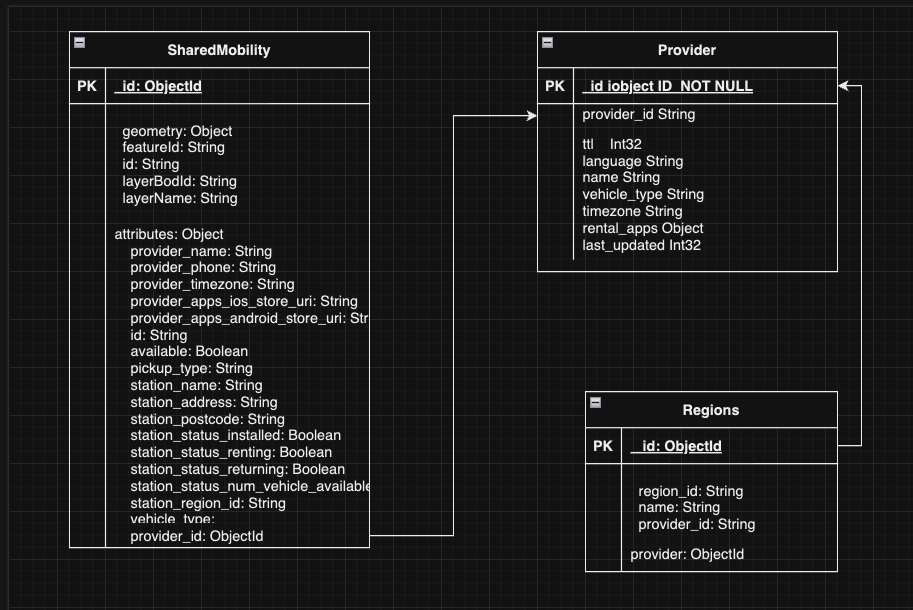


#### Transformed Data Structure 

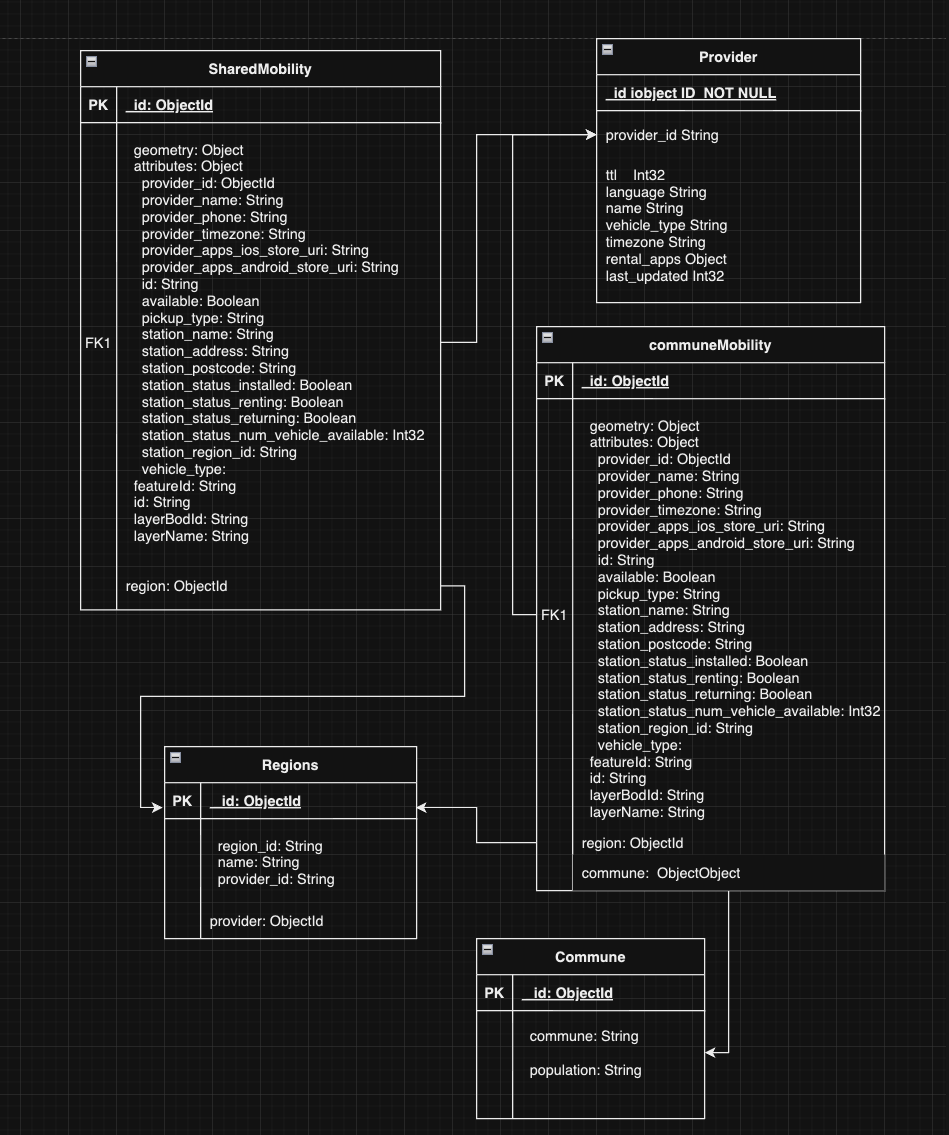


## Extract

#### Shared Mobility Provider Api

In [8]:

# Insert and update if exist 

def fetch_data_and_insert(url, params, connection_url, collection_name):
    try:
        # Request the data from the API
        r = requests.get(url, params=params)
        
        # Check if the request was successful
        if r.ok:
            data = r.json()
            # Insert the fetched data into the database
            insert_datas(data, connection_url, collection_name)
            print("Data fetched successfully.")
        else:
            print("Failed to fetch data from the API.")
    except Exception as e:
        #  the error
        print(f"Error fetching data: {e}")

In [9]:
provider_api = 'https://api.sharedmobility.ch/v1/sharedmobility/providers'
params = {}
collection_name = "Testproviders"

fetch_data_and_insert(provider_api, params, connection_url, collection_name)

Error fetching data: name 'insert_datas' is not defined


In [4]:
# get one sharedMobility from MongoDB
pymongo.MongoClient(connection_url).noSql.sharedMobility.find_one()

{'_id': ObjectId('653a9dd34e7c8125f6c0eb1c'),
 'geometry': {'x': 6.634662, 'y': 46.533623},
 'attributes': {'provider_id': '2em_cars',
  'provider_name': '2EM Car Sharing',
  'provider_phone': '0041 58 255 28 66',
  'provider_timezone': 'Europe/Zurich',
  'provider_apps_ios_store_uri': 'https://apps.apple.com/fr/app/2em-car-sharing/id1517096697',
  'provider_apps_ios_discovery_uri': 'ch.2em://',
  'provider_apps_android_store_uri': 'ch.2em://',
  'provider_apps_android_discovery_uri': 'https://play.google.com/store/apps/details?id=ch.app2em',
  'id': '2em_cars:122',
  'available': True,
  'pickup_type': 'station_based',
  'station_name': 'Seat Leon 2017',
  'station_status_installed': True,
  'station_status_renting': True,
  'station_status_returning': True,
  'station_status_num_vehicle_available': 1,
  'vehicle_type': 'Car'},
 'featureId': '2em_cars:122',
 'id': '2em_cars:122',
 'layerBodId': 'ch.bfe.sharedmobility',
 'layerName': 'Shared Mobility Angebote'}

####  Shared Mobility Region Api

In [11]:
#update of insert region 
def update_region_insert_data(datas, connection_url, collection_name):
    updated_count = 0
    inserted_count = 0

    try:
        # Connect to MongoDB using the provided connection URL
        client = pymongo.MongoClient(connection_url)
        db = client["noSql"]
        collection = db[collection_name]

        for data in datas:
       
            try:
                # Extract the "provider_id" from the data
                provider_id = data["provider_id"]
                
                # Check if the "provider_id" exists in the "provider" collection
                provider_data = db["providers"].find_one({"provider_id": provider_id})
                if provider_data:
                   data["provider_id"] = provider_data["_id"]
                else:
                    print("reference not present in providers collection" )
                    continue

                # Attempt to insert the data
                collection.insert_one(data)
                inserted_count += 1
            except pymongo.errors.DuplicateKeyError:
                # Handle the duplicate key error by incrementing the updated_count
                updated_count += 1
                continue  # Move to the next item in the loop

        # Close the MongoDB connection
        client.close()
    except Exception as e:
        print(f"Error updating or inserting data: {e}")

    print(f"Already exist {updated_count} documents and inserted {inserted_count} new documents.")
# fetch region from API 
def fetch_region_and_insert(url, params, connection_url, collection_name):
    try:
        # Request the data from the API
        r = requests.get(url, params=params)
        
        # Check if the request was successful
        if r.ok:
            datas = r.json()
            # Insert the fetched data into the database
            print("Data fetched successfully.")
            update_region_insert_data(datas, connection_url, collection_name)
        else:
            print("Failed to fetch data from the API.")
    except Exception as e:
        # Log the error
        logging.error(f"Error fetching data: {e}")
        print(f"Error fetching data: {e}")

In [12]:
regions_api = 'https://api.sharedmobility.ch/v1/sharedmobility/regions'
params = {}
collection_name = "regions"
 
fetch_region_and_insert(regions_api, params, connection_url, collection_name)

Data fetched successfully.
Already exist 0 documents and inserted 139 new documents.


In [13]:
# get one Region from MongoDB 

pymongo.MongoClient(connection_url).noSql.regions.find_one()

{'_id': ObjectId('6538cd84de5cde2af199a867'),
 'region_id': 'donkey_ge:627',
 'name': 'Donkey Geneva',
 'provider_id': 'donkey_ge',
 'provider': ObjectId('6538adecde5cde2af1999341')}

#### Commune Data DB insertion 

In [14]:
# read communes data from csv_file 
commune = pd.read_csv("Swiss_commune.csv", dtype={"commune": str, "population": str})

#DB communes function 
def insert_commmune(datas, connection_url, collection_name ):
    try:
        # Connect to MongoDB using the provided connection URL
        client = pymongo.MongoClient(connection_url)
        db = client["noSql"]
        collection = db[collection_name]

        datas = datas.to_dict(orient='records')
   
        collection.insert_many(datas)

        # Close the MongoDB connection
        client.close()
        print("Data insertion successful.")
    except Exception as e:
        print(f"Error inserting data: {e}")

In [15]:
insert_commmune(commune, connection_url, "commune")

Data insertion successful.


In [16]:
# get one commune from MongoDB
pymongo.MongoClient(connection_url).noSql.commune.find_one()

{'_id': ObjectId('653c7df1b332f5e02f3edf30'),
 'commune': 'Affoltern am Albis',
 'population': '12,303'}

### Original Station datas from API filter with "Vehicle Type" and DB inset 

#### retrieve Vehecle type from Providers

In [18]:
import pymongo

def retrieve_vehicle_types(connection_url, collection_name):
    try:
        # Connect to MongoDB using the provided connection URL
        client = pymongo.MongoClient(connection_url)
        db = client["noSql"]
        collection = db[collection_name]

        # Define the aggregation pipeline
        pipeline = [
            {
                "$group": {
                    "_id": "$vehicle_type",
                }
            },
            {
                "$project": {
                    "_id": 0,
                    "vehicle_type": "$_id",
                }
            }
        ]

        # Execute the aggregation pipeline
        result = list(collection.aggregate(pipeline))

        # Extract the unique vehicle types from the result
        vehicle_types = [item["vehicle_type"] for item in result]

        # Close the MongoDB connection
        client.close()

        return vehicle_types

    except Exception as e:
        print(f"Error retrieving vehicle types from MongoDB: {e}")
        return []



#### retrive original data per vehicle type

In [19]:
# Function for get data from API with vehicle_type, 
def retrieve_data_with_vehicle_type(vehicle_type, num_requests=5):
    # Initialize an empty list to store the data
    response_data = []

    url = 'https://api.sharedmobility.ch/v1/sharedmobility/find'

    # Initialize the offset
    offset = 0

    for i in range(num_requests):
        # Construct the parameters dictionary for each request
        params = {
            "filters": f"ch.bfe.sharedmobility.vehicle_type={vehicle_type}",
            "searchField": "ch.bfe.sharedmobility.station.name",
            "offset": offset,
            "geometryFormat": "esrijson",
        }

        # Request the data from the API
        response = requests.get(url, params=params)

        # Check if the request was successful
        if response.ok:
            data = response.json()
            # Process the data as needed
            response_data.extend(data)
            print(f"Data retrieved and combined successfully for round {i + 1}!")

            # If the response is empty, stop making requests
            if not data:
                break

            # Increment the offset by 50 for the next request
            offset += 50
        else:
            print("Error: Unable to retrieve data from the API.")

    return response_data

In [ ]:


def update_2_vehicles_insert_data(datas, connection_url, collection_name):
    updated_count = 0
    inserted_count = 0
    print(f"collection_name: {collection_name}")

    try:
        # Connect to MongoDB using the provided connection URL
        client = pymongo.MongoClient(connection_url)
        db = client["noSql"]
        collection = db[collection_name]

        for data in datas:
            try:
                # Ensure that the "attributes" field references the "attributes" collection
                attributes_data = data.get("attributes", {})

                # Convert "x" and "y" coordinates to a GeoJSON Point
                x = attributes_data.get("x")
                y = attributes_data.get("y")
                if x is not None and y is not None:
                    data["geometry"] = {
                        "type": "Point",
                        "coordinates": [x, y]
                    }

                # Check if the "provider_id" field exists and use it for reference
                provider_id = attributes_data.get("provider_id")
                if provider_id:
                    region_data = db["regions"].find_one({"provider_id": provider_id})
                    if region_data:
                        data["region"] = region_data["_id"]
                    # else:
                    #     print(f"Provider ID not found: {provider_id}")
                    #     # continue

                # Remove "x" and "y" fields from "attributes"
                attributes_data.pop("x", None)
                attributes_data.pop("y", None)

                # Remove "spatialReference" field under "geometry"
                data.get("geometry", {}).pop("spatialReference", None)

                # Attempt to insert the data
                collection.insert_one(data)
                inserted_count += 1

            except pymongo.errors.DuplicateKeyError:
                # Handle the duplicate key error by incrementing the updated_count
                updated_count += 1
                continue  # Move to the next item in the loop

        # Close the MongoDB connection
        client.close()
    except Exception as e:
        print(f"Error updating or inserting data: {e}")

    print(f"Already exist {updated_count} documents and inserted {inserted_count} new documents.")


In [20]:
collection_name = 'providers'
vehicle_types = retrieve_vehicle_types(connection_url, collection_name)
print(vehicle_types)

['Bike', 'Car', 'E-CargoBike', 'E-Bike', 'E-Moped', 'E-Car', 'E-Scooter']


In [ ]:
station_dic = {}
for v_type in vehicle_types:
    station_result = retrieve_data_with_vehicle_type(v_type, 50)
    v_list = replace_dots_with_underscores(station_result)
    # update_vehicles_insert_data(v_list, connection_url, v_type)
    update_2_vehicles_insert_data(v_list, connection_url, "sharedMobility")
    print(f"{v_type} in MongoDB now !")
    # station_dic[v_type] = station_result
print("Ends!")

In [22]:
# get one commune from MongoDB
pymongo.MongoClient(connection_url).noSql.commune.find_one()

{'_id': ObjectId('653c7df1b332f5e02f3edf30'),
 'commune': 'Affoltern am Albis',
 'population': '12,303'}

### Station API fetch data with  " Commune Keyword", transform  & DB insert
First, retrieve a list of all communes from MongoDB. Then, perform searches on https://api.sharedmobility.ch using each commune name as a keyword. 
As we iterate through the loop, we insert each commune name as an embedded document into the "communeMobility" collection. This allows us to later 
access the population information from the "commune" collection using the commune name. 


In [23]:
# retrieve data from commmune collection 
def find_commune (db_url, collection_name):
    client = pymongo.MongoClient(db_url)
    db = client.get_database()

    # Create a lookup stage to join data from "commune" collection based on the "commune" field


    # Define the projection stage to select the desired fields
    project_stage = {
        "$project": {
            "_id": 0,
            "commune": "$commune",
        }
    }

    pipeline = [
        project_stage,
    ]

    result = list(db.get_collection(collection_name).aggregate(pipeline))

    # commune_df = pd.DataFrame(result)

    # client.close()
    print("Data retrieval finished!")

    return result

In [24]:
# Insert station datas joint with Communes data

def update_commune_insert_data(datas, commune, connection_url, collection_name):
    updated_count = 0
    inserted_count = 0
    print(f"collection_name: {collection_name}")

    try:
        # Connect to MongoDB using the provided connection URL
        client = pymongo.MongoClient(connection_url)
        db = client["noSql"]
        collection = db[collection_name]

        for data in datas:
            try:
                # Ensure that the "attributes" field references the "attributes" collection
                attributes_data = data.get("attributes", {})

                # Convert "x" and "y" coordinates to a GeoJSON Point
                x = attributes_data.get("x")
                y = attributes_data.get("y")
                if x is not None and y is not None:
                    data["geometry"] = {
                        "type": "Point",
                        "coordinates": [x, y]
                    }

                # Check if the "provider_id" field exists and use it for reference
                provider_id = attributes_data.get("provider_id")
                if provider_id:
                    region_data = db["regions"].find_one({"provider_id": provider_id})
                    if region_data:
                        data["region"] = region_data["_id"]
                    # else:
                    #     print(f"Provider ID not found: {provider_id}")
                    #     # continue

                # Remove "x" and "y" fields from "attributes"
                attributes_data.pop("x", None)
                attributes_data.pop("y", None)

                # Remove "spatialReference" field under "geometry"
                data.get("geometry", {}).pop("spatialReference", None)

                data["commune"] = commune

                # Attempt to insert the data
                collection.insert_one(data)
                inserted_count += 1

            except pymongo.errors.DuplicateKeyError:
                # Handle the duplicate key error by incrementing the updated_count
                updated_count += 1
                continue  # Move to the next item in the loop

        # Close the MongoDB connection
        # client.close()
    except Exception as e:
        print(f"Error updating or inserting data: {e}")

    print(f"Already exist {updated_count} documents and inserted {inserted_count} new documents.")

In [25]:
commune_names = find_commune(connection_url, collection_name = "commune")

Data retrieval finished!


In [27]:
# Function for get data from API with text search, 
def retrieve_data_with_key_word(keyword, num_requests=1):
    response_data = []

    url = 'https://api.sharedmobility.ch/v1/sharedmobility/find'

    # Initialize the offset
    offset = 0

    for i in range(num_requests):

        # Construct the parameters dictionary for each request
        params = {
            "searchText": keyword,
            "searchField": "ch.bfe.sharedmobility.station.name",
            "offset": offset,
            "geometryFormat": "esrijson",
        }

        # Request the data from the API
        response = requests.get(url, params=params)

        # Check if the request was successful
        if response.ok:
            data = response.json()
            # Process the data as needed
            response_data.extend(data)
            print(f"Data retrieved and combined successfully for round {i + 1}!")

            # If the response is empty, stop making requests
            if not data:
                break

            # Increment the offset by 50 for the next request
            offset += 50
        else:
            print("Error: Unable to retrieve data from the API.")

    return response_data

In [31]:
# loop communes and get moboility and insert to DB 

for commune in commune_names:
    station_result = retrieve_data_with_key_word(commune)
    v_list = replace_dots_with_underscores(station_result)
    update_commune_insert_data(v_list, commune, connection_url, "communeMobility")
print("Ends!")

## Load Data & Exploratory

#### load Original data

In [32]:
def find_shared_mobility_data(db_url, collection_name):
    client = pymongo.MongoClient(db_url)
    db = client.get_database()

    match_stage = {
        "$match": {
            "attributes.available": True
        }
    }

    project_stage = {
        "$project": {
            "_id": 0,
            "provider_id": "$attributes.provider_id",
            "provider_name": "$attributes.provider_name",
            "id": "$attributes.id",
            "available": "$attributes.available",
            "station": "$attributes.station_name",
            "station_status_num_vehicle_available": "$attributes.station_status_num_vehicle_available",
            "vehicle_type": "$attributes.vehicle_type",
            "geometry": "$geometry",
        }
    }

    pipeline = [
        match_stage,
        project_stage,  # Include the flattening stage
    ]

    result = db.get_collection(collection_name).aggregate(pipeline)

    data_df = pd.DataFrame(result)

    client.close()
    print("Data retrieval finished!")

    return data_df


In [33]:
result = find_shared_mobility_data(connection_url, "sharedMobility")


Data retrieval finished!


In [34]:
result.head()

,provider_id,provider_name,id,available,station,station_status_num_vehicle_available,vehicle_type,geometry
0,2em_cars,2EM Car Sharing,2em_cars:122,True,Seat Leon 2017,1.0,Car,"{'x': 6.634662, 'y': 46.533623}"
1,2em_cars,2EM Car Sharing,2em_cars:70,True,velo 1995,1.0,Car,"{'x': 6.932318, 'y': 46.99388}"
2,2em_cars,2EM Car Sharing,2em_cars:83,True,BC BMC 2005,1.0,Car,"{'x': 6.821634, 'y': 47.097874}"
3,2em_cars,2EM Car Sharing,2em_cars:84,True,BC Price 2008,1.0,Car,"{'x': 6.821634, 'y': 47.097874}"
4,2em_cars,2EM Car Sharing,2em_cars:87,True,BC Mazza 1988,1.0,Car,"{'x': 8.563731, 'y': 47.4381}"


In [35]:
result.dtypes

provider_id                              object
provider_name                            object
id                                       object
available                                  bool
station                                  object
station_status_num_vehicle_available    float64
vehicle_type                             object
geometry                                 object
dtype: object

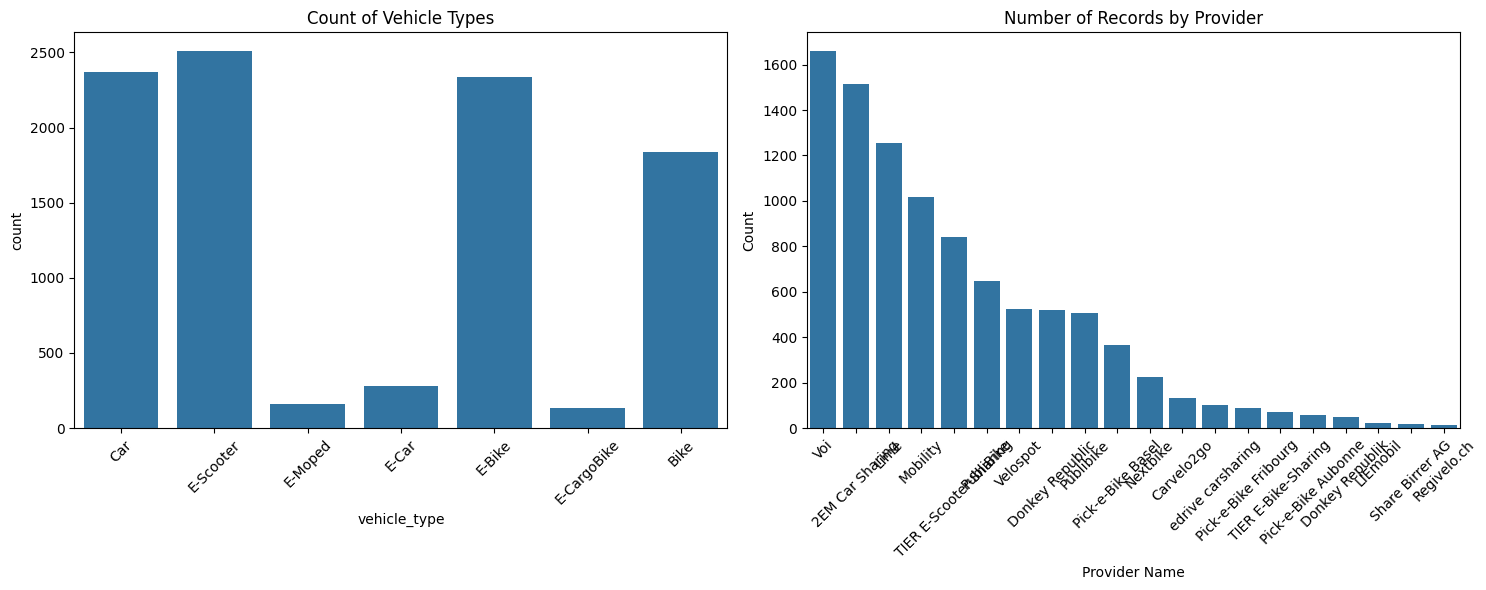

In [36]:
# Create a figure with two subplots
df = result 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot the first subplot (Count of Vehicle Types)
sns.countplot(data=df, x='vehicle_type', ax=ax1)
ax1.set_title('Count of Vehicle Types')

# Set custom ticks and labels, and rotate them
ax1.set_xticks(range(len(df['vehicle_type'].unique())))
ax1.set_xticklabels(df['vehicle_type'].unique(), rotation=45)

# Count the number of records per provider_name
provider_counts = df['provider_name'].value_counts()

# Plot the second subplot (Number of Records by Provider)
sns.barplot(x=provider_counts.index, y=provider_counts.values, ax=ax2)
ax2.set_title('Number of Records by Provider')
ax2.set_xlabel('Provider Name')
ax2.set_ylabel('Count')

# Set custom ticks and labels, and rotate them
ax2.set_xticks(range(len(provider_counts.index)))
ax2.set_xticklabels(provider_counts.index, rotation=45)

# Display the plots
plt.tight_layout()
plt.show()

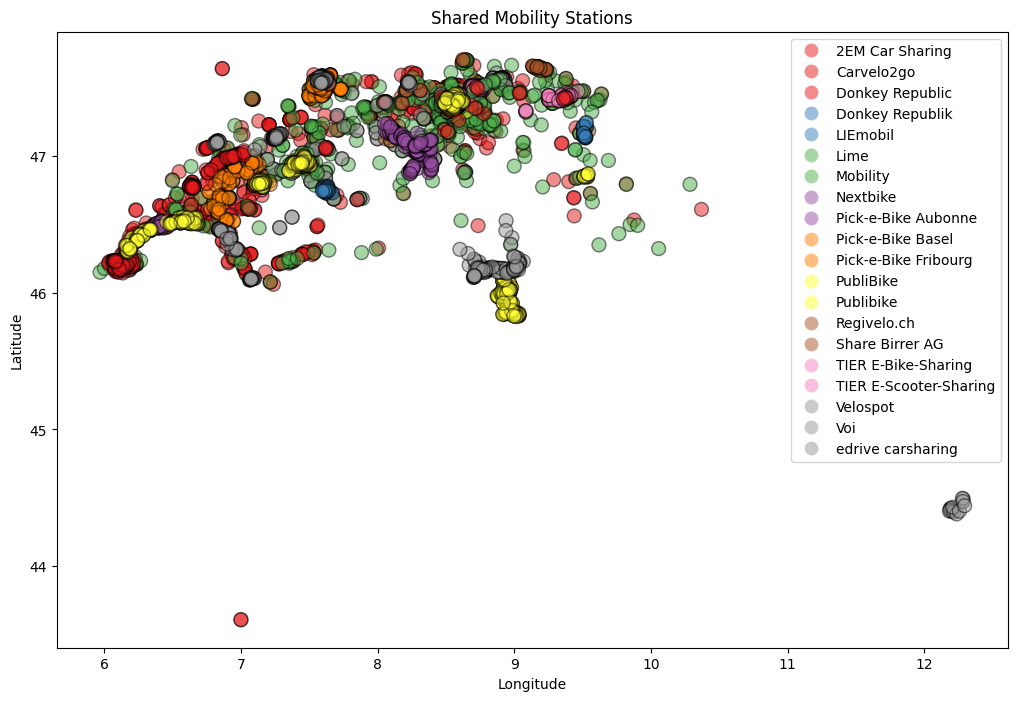

In [37]:
# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(result, geometry=gpd.points_from_xy([item['x'] for item in result["geometry"]], [item['y'] for item in result["geometry"]]))

# Geospatial plot
ax = gdf.plot(column='provider_name', cmap='Set1', legend=True, markersize=100, alpha=0.5, edgecolor='k', figsize=(16, 8))
plt.title('Shared Mobility Stations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

### Find stations with communes and population 

This dataset will be used for our analysis. We will extract the necessary values from it.

In [38]:

def find_commune_mobility_with_population(db_url, mobility_collection, limit=0):
    client = pymongo.MongoClient(db_url)
    db = client.get_database()

    # Create a lookup stage to join data from "commune" collection based on the "commune" field
    lookup_stage = {
        "$lookup": {
            "from": "commune",
            "localField": "commune.commune",
            "foreignField": "commune",
            "as": "population_data"
        }
    }

    # Define the projection stage to select the desired fields
    project_stage = {
        "$project": {
           "_id": 0,
            # "provider_id": "$attributes.provider_id",
            "provider_name": "$attributes.provider_name",
            # "id": "$attributes.id",
            # "available": "$attributes.available",
            # "station": "$attributes.station_name",
            "station_status_num_vehicle_available": "$attributes.station_status_num_vehicle_available",
            "vehicle_type": "$attributes.vehicle_type",
            "geometry": "$geometry",
            "commune": "$commune.commune",
            "population": {
                "$arrayElemAt": ["$population_data.population", 0]
            }
        }
    }
        # Add the $limit stage to the pipeline if a limit is specified
    if limit > 0:
        limit_stage = {"$limit": limit}
        pipeline = [
            lookup_stage,
            project_stage,
            limit_stage
        ]
    else:
        pipeline = [
            lookup_stage,
            project_stage,
        ]

    result = db.get_collection(mobility_collection).aggregate(pipeline)

    data_df = pd.DataFrame(result)

    client.close()
    print("Data retrieval finished!")

    return data_df




In [39]:
result = find_commune_mobility_with_population(connection_url, "communeMobility", 0)
result

Data retrieval finished!


,provider_name,station_status_num_vehicle_available,vehicle_type,geometry,commune,population
0,edrive carsharing,1,E-Car,"{'x': 7.9900217, 'y': 47.213226}",Männedorf,"11,359"
1,edrive carsharing,1,E-Car,"{'x': 7.848944, 'y': 47.18606}",Männedorf,"11,359"
2,edrive carsharing,1,E-Car,"{'x': 7.618952, 'y': 46.83722}",Männedorf,"11,359"
3,edrive carsharing,1,E-Car,"{'x': 7.520684, 'y': 47.043728}",Männedorf,"11,359"
4,edrive carsharing,1,E-Car,"{'x': 8.50224, 'y': 47.380066}",Männedorf,"11,359"
...,...,...,...,...,...,...
45219,Carvelo2go,1,E-CargoBike,"{'x': 7.4493465, 'y': 46.94864}",Kappel am Albis,"1,221"
45220,Carvelo2go,1,E-CargoBike,"{'x': 8.489381, 'y': 47.189358}",Kappel am Albis,"1,221"
45221,Carvelo2go,1,E-CargoBike,"{'x': 6.129573, 'y': 46.229008}",Kappel am Albis,"1,221"
45222,Carvelo2go,1,E-CargoBike,"{'x': 6.141205, 'y': 46.210487}",Kappel am Albis,"1,221"


In [40]:
result.dtypes

provider_name                           object
station_status_num_vehicle_available     int64
vehicle_type                            object
geometry                                object
commune                                 object
population                              object
dtype: object

### Annalysis

In [41]:
# Define criteria
high_vehicle_variety_threshold = 3  # Example: More than 3 vehicle types is "high."
high_station_threshold = 90  # Example: More than 10 available stations is "high."

# Function to categorize accessibility
def categorize_accessibility(row):
    if row['unique_vehicle_types'] > high_vehicle_variety_threshold and row['station_count'] > high_station_threshold:
        return 'High'
    elif row['unique_vehicle_types'] > high_vehicle_variety_threshold or row['station_count'] > high_station_threshold:
        return 'Moderate'
    else:
        return 'Low'

# Calculate unique vehicle types and count stations for each commune
commune_stats = result.groupby('commune').agg({
    'vehicle_type': 'nunique',
    'station_status_num_vehicle_available': 'sum'
}).reset_index()
commune_stats.columns = ['commune', 'unique_vehicle_types', 'station_count']

# Categorize accessibility and add a new column
commune_stats['accessibility'] = commune_stats.apply(categorize_accessibility, axis=1)

# # Merge the accessibility information back into the original dataset with explicit suffixes
# result = result.merge(commune_stats[['commune', 'accessibility']], on='commune', how='left', suffixes=('_left', '_right'))

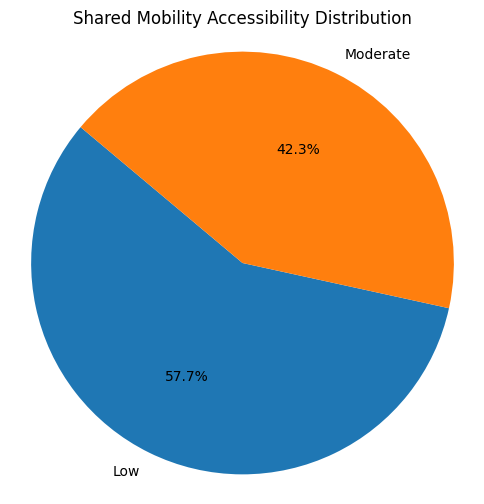

In [42]:

# Assuming you have a DataFrame named 'result' with an 'accessibility' column
accessibility_counts = commune_stats['accessibility'].value_counts()

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(accessibility_counts, labels=accessibility_counts.index, autopct='%1.1f%%', startangle=140)

# Add a title
plt.title('Shared Mobility Accessibility Distribution')

# Display the pie chart
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Here, we groups the dataset according to the values in the 'vehicle_type,' 'provider_name,' 'population,' and 'commune' columns, summarize data from a dataset. Then, within these groups, it calculates the sum of the 'station_status_num_vehicle_available' column. These aggregated results are stored in a new DataFrame referred to as 'car_sum.' Essentially, 'car_sum' contains the accumulated values for each unique combination of 'vehicle_type,' 'provider_name,' 'population,' and 'commune.', this we going to use for further analysis.


In [43]:
# Group the data by 'vehicle_type' and 'commune', and sum the 'station_status_num_vehicle_available' column
result['population'] = result['population'].str.replace(',', '', regex=True).astype(float)
car_sum = result.groupby(['station_status_num_vehicle_available', 'provider_name',  'population',  'vehicle_type'])['commune'].sum().reset_index()

print(car_sum.tail(20))

      station_status_num_vehicle_available provider_name  population  \
9808                                     9     PubliBike     16893.0   
9809                                     9     PubliBike     16933.0   
9810                                     9     PubliBike     17468.0   
9811                                     9     PubliBike     17910.0   
9812                                     9     PubliBike     18399.0   
9813                                     9     PubliBike     18626.0   
9814                                     9     PubliBike     19181.0   
9815                                     9     PubliBike     21090.0   
9816                                     9     PubliBike     21449.0   
9817                                     9     PubliBike     23871.0   
9818                                     9     PubliBike     24617.0   
9819                                     9     PubliBike     30618.0   
9820                                     9     PubliBike     366

#### Correlation 
Here we try to find correlation between the 'population' and 'station_status_num_vehicle_available' variables in the dataset.  Explore their potential relationship. Specifically, it aims to understand whether there is a statistical association or dependence between these two variables and the strength and direction of this relationship. And, validate assumptions and furthur analysis. 

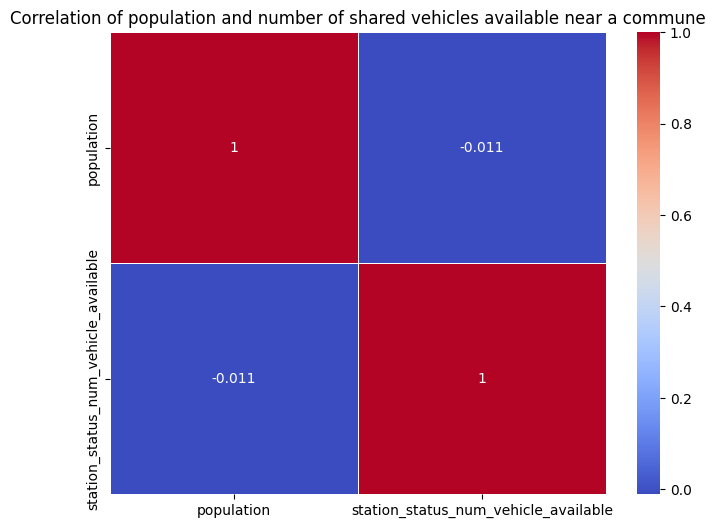

In [44]:
# Remove commas from the "population" column and convert to float
# car_sum['population'] = car_sum['population'].str.replace(',', '', regex=True).astype(float)

# Calculate the correlation matrix
correlation_matrix = car_sum[['population', 'station_status_num_vehicle_available']].corr()

# Create a heatmap to visualize the correlation
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation of population and number of shared vehicles available near a commune')
plt.show()


based on this correlation matrix, there is no meaningful linear relationship between 'population' and 'station_status_num_vehicle_available'. They appear to be largely unrelated in terms of their linear association.

#### support vector machine (SVM)
The SVM model's purpose is to learn patterns and relationships within the dataset by using these variables to classify data points. It aims to understand whether the combination of the number of available shared vehicles and the population of a commune can predict the type of shared vehicle, which is the target variable ("vehicle_type"). In essence, the model is designed to distinguish between different types of shared vehicles, such as E-Bikes, E-Cars, and E-CargoBikes, based on these two features.


In [45]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn import preprocessing


In [46]:
# Separate the target variable and features
numeric_columns = ['station_status_num_vehicle_available', 'population']
X = result[numeric_columns]

Y = result['vehicle_type']

# Scale the features using preprocessing
from sklearn import preprocessing
X = preprocessing.scale(X)


In [47]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

def print_score(model, X_train, y_train, X_test, y_test, train=True):
    if train:
        y_pred = model.predict(X_train)
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, y_pred) * 100:.2f}%")
        print("_______________________________________________")
        print("CLASSIFICATION REPORT:\n", classification_report(y_train, y_pred, zero_division=0.0))
        print("Confusion Matrix: \n", confusion_matrix(y_train, y_pred))
        
    elif not train:
        y_pred = model.predict(X_test)
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, y_pred) * 100:.2f}%")
        print("_______________________________________________")
        print("CLASSIFICATION REPORT:\n", classification_report(y_test, y_pred, zero_division=0.0))
        print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))


In [48]:
#split data into train and test (standard 80:20 split)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [49]:
# The hyperparameter coef0 controls how much the model is influenced by high degree ploynomials 
model = SVC(kernel='poly', degree=2, gamma='auto', coef0=1, C=5)

model.fit(X_train, y_train)
print_score(model, X_train, y_train, X_test, y_test, train=True)
print_score(model, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 71.55%
_______________________________________________
CLASSIFICATION REPORT:
               precision    recall  f1-score   support

      E-Bike       1.00      0.63      0.77     12310
       E-Car       0.00      0.00      0.00      5741
 E-CargoBike       0.64      1.00      0.78     18128

    accuracy                           0.72     36179
   macro avg       0.55      0.54      0.52     36179
weighted avg       0.66      0.72      0.65     36179

Confusion Matrix: 
 [[ 7757     0  4553]
 [    0     0  5741]
 [    0     0 18128]]
Test Result:
Accuracy Score: 71.01%
_______________________________________________
CLASSIFICATION REPORT:
               precision    recall  f1-score   support

      E-Bike       1.00      0.63      0.78      3058
       E-Car       0.00      0.00      0.00      1499
 E-CargoBike       0.63      1.00      0.77      4488

    accuracy                           0.71      9045
   macro avg       0.54      0.54      0.52   

The model performs well in distinguishing between E-Bike and E-CargoBike but has difficulty classifying E-Car. The primary expected outcome of the model is to accurately classify vehicle types based on the number of available vehicles and population, and it succeeds to a reasonable extent. However, further improvement may be needed to enhance the classification of E-Car. The similarity in accuracy between the training and test datasets suggests that the model generalizes adequately, but it might require more data or feature engineering to better classify E-Car. The classification report provides detailed information on precision, recall, and F1-scores, helping to identify areas for improvement.

## Conclusion
This project showcases the application of data data structure and analytics for comprehending shared mobility services. It highlights the importance of proper data pre-processing, data modelling and storage using MongoDB. Data visualisation of the dataset to gain meaningful insights, we performed some machine learning model analysis of a shared mobility dataset to gain insights, we also performed a simulation to categorise the accessibility and availability of vehicles in different communities.

The project consisted of several key components:

### Data Preparation

We started by cleaning and preprocessing the dataset. This involved handling missing values, data type conversions, and feature extraction.

### Data Exploration

We explored the dataset to better understand the distribution of variables, such as vehicle types, provider names, and the number of available stations in communes.

### Correlation Analysis

We performed a correlation analysis to assess the relationship between the population of communes and the number of shared vehicles available. The results indicated a weak negative correlation, suggesting that population size does not strongly influence vehicle availability.

### Machine Learning Model

To predict vehicle types based on available features, we built a classification model using the Support Vector Machine (SVM) algorithm. The model achieved an accuracy of around 71% on both training and test datasets.

### Accessibility Categorization

We introduced a categorization scheme for accessibility, classifying communes as "High," "Moderate," or "Low" based on vehicle variety and station availability.

### Data Visualization

We employed various data visualization techniques, including bar plots and pie charts, to visually represent the accessibility categories and make the data more comprehensible.



## Learning

The foundation of any robust data analytics project lies in data integrity, efficient modelling and an appropriate storage mechanism. In this project, the flexibility and scalability of MongoDB recognises their key role in unlocking meaningful insights. Careful data modelling, including filtering and structuring, was critical in preparing the data for deeper analysis, but also where and how it was stored. MongoDB, a flexible and scalable NoSQL database, has served as a robust repository, enabling seamless data integration and retrieval, and the integrity of our data and the efficiency of our modelling filtering mechanisms remain central to the success of the project.
Building on what we have learnt, we are also focusing on what we can do better for future projects.

- Future work could include collecting more comprehensive data, including additional demographic and geographic factors that might differentiate urban and suburban areas and impact shared mobility services, 
- Exploring advanced machine learning models and feature engineering could potentially improve prediction accuracy, forecasting and prediction.
- A more detailed analysis of the presence of each vehicle type in different municipalities could provide valuable insights.
- Temporal trends in shared mobility services could be further explored.

  ### Key Takeaways

- The correlation analysis pointed out that factors other than population size influence vehicle availability in communes.
- The SVM classification model demonstrated decent predictive capabilities for identifying vehicle types.